# Linking SDG&E utility data with building polygons
This notebook will take Global Building Atlas polygons and link to the nearest SDG&E feeder line.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import glob
import os
import folium

In [2]:
# create a bbox  for san diego
bbox = box(-117.259939,32.669123,-117.054289,32.780034)
bbox = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Read in SDGE line data

In [3]:
sdge_feederlines = gpd.read_file("../../../../capstone/electrigrid/data/utilities/sandiego_grid/lines_sdge.geojson")

In [4]:
sdge_feederlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# convert to projected crs
sdge_feederlines = sdge_feederlines.to_crs(epsg=4326)

In [6]:
# Clip circuits to bbox
sdge_feederlines = gpd.clip(sdge_feederlines, bbox)
sdge_feederlines.head()

,SUBID,OBJECTID,VOLTAGE,LINE_SEGMENT_NUMBER,ICAWOF_UNIGENERATION,ICAWOF_UNILOAD,ICAWOF_PVGENERATION,OHUG,CIRCUIT_NAME,LABELTEXT,ICAWNOF_UNIGENERATION,ICAWNOF_UNILOAD,ICAWNOF_PVGENERATION,LABELTEXT_ICA,RESTRICTED,ICAWOF_UNIGENERATION_LC,ICAWOF_UNILOAD_LC,ICAWNOF_UNIGENERATION_LC,substations,geometry
95,SWEETWATER,32580779,12,1699876,2.6,0.1,3.2,UG,41,None,2.6,0.1,3.2,Above 2,N,ICA_Voltage,Load_Thermal,ICA_Voltage,SWEETWATER,"MULTILINESTRING ((-117.09619 32.67215, -117.09..."
65,PARADISE,32507484,12,13442,0.0,1.0,0.5,UG,320,None,1.8,1.0,1.8,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,PARADISE,"MULTILINESTRING ((-117.06866 32.68430, -117.06..."
79,SAMPSON,32503863,12,28169,0.0,2.7,0.0,OH,130,None,2.7,2.7,3.1,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,SAMPSON,"MULTILINESTRING ((-117.15886 32.70580, -117.15..."
102,WABASH CANYON,32839681,12,1011381,0.1,1.8,0.1,UG,1418,None,0.6,1.8,0.9,Up to 1.00,N,ICA_Operation_Flex,Load_Voltage,ICA_Voltage_Delta,WABASH CANYON,"MULTILINESTRING ((-117.09384 32.72216, -117.09..."
15,CHOLLAS WEST,32503766,12,1845491,-0.1,0.8,0.1,OH,1047,None,2.2,0.8,2.7,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Voltage_Delta,CHOLLAS WEST,"MULTILINESTRING ((-117.06213 32.72974, -117.06..."


# Reading in Building data

In [7]:
path = "../../../../capstone/electrigrid/data/buildings/w120_n35_w115_n30.parquet"
buildings = gpd.read_parquet(path)

In [8]:
buildings.crs

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Convert buildings crs & clip to sdge
buildings = buildings.to_crs(epsg=4326)
buildings_clip = gpd.clip(buildings, bbox)

In [10]:
buildings_clip.head()

,source,id,height,var,region,bbox,geometry
7107089,osm,15966214,1.377874,0.991099,USA,"{'xmin': -117.24165519999998, 'ymin': 32.67039...","POLYGON ((-117.24163 32.67045, -117.24161 32.6..."
7107085,osm,67487419,2.999929,2.747906,USA,"{'xmin': -117.241352, 'ymin': 32.6716877, 'xma...","POLYGON ((-117.24133 32.67177, -117.24132 32.6..."
7107086,osm,133055012,3.113471,3.369538,USA,"{'xmin': -117.2409694, 'ymin': 32.6717891, 'xm...","POLYGON ((-117.24096 32.67190, -117.24091 32.6..."
7107101,osm,90687227,3.667810,3.329592,USA,"{'xmin': -117.2410468, 'ymin': 32.671931300000...","POLYGON ((-117.24101 32.67204, -117.24094 32.6..."
7107102,osm,1177231469,2.633681,1.875980,USA,"{'xmin': -117.2407876, 'ymin': 32.6720196, 'xm...","POLYGON ((-117.24079 32.67204, -117.24078 32.6..."


# Plot buildings and grid together

<Axes: >

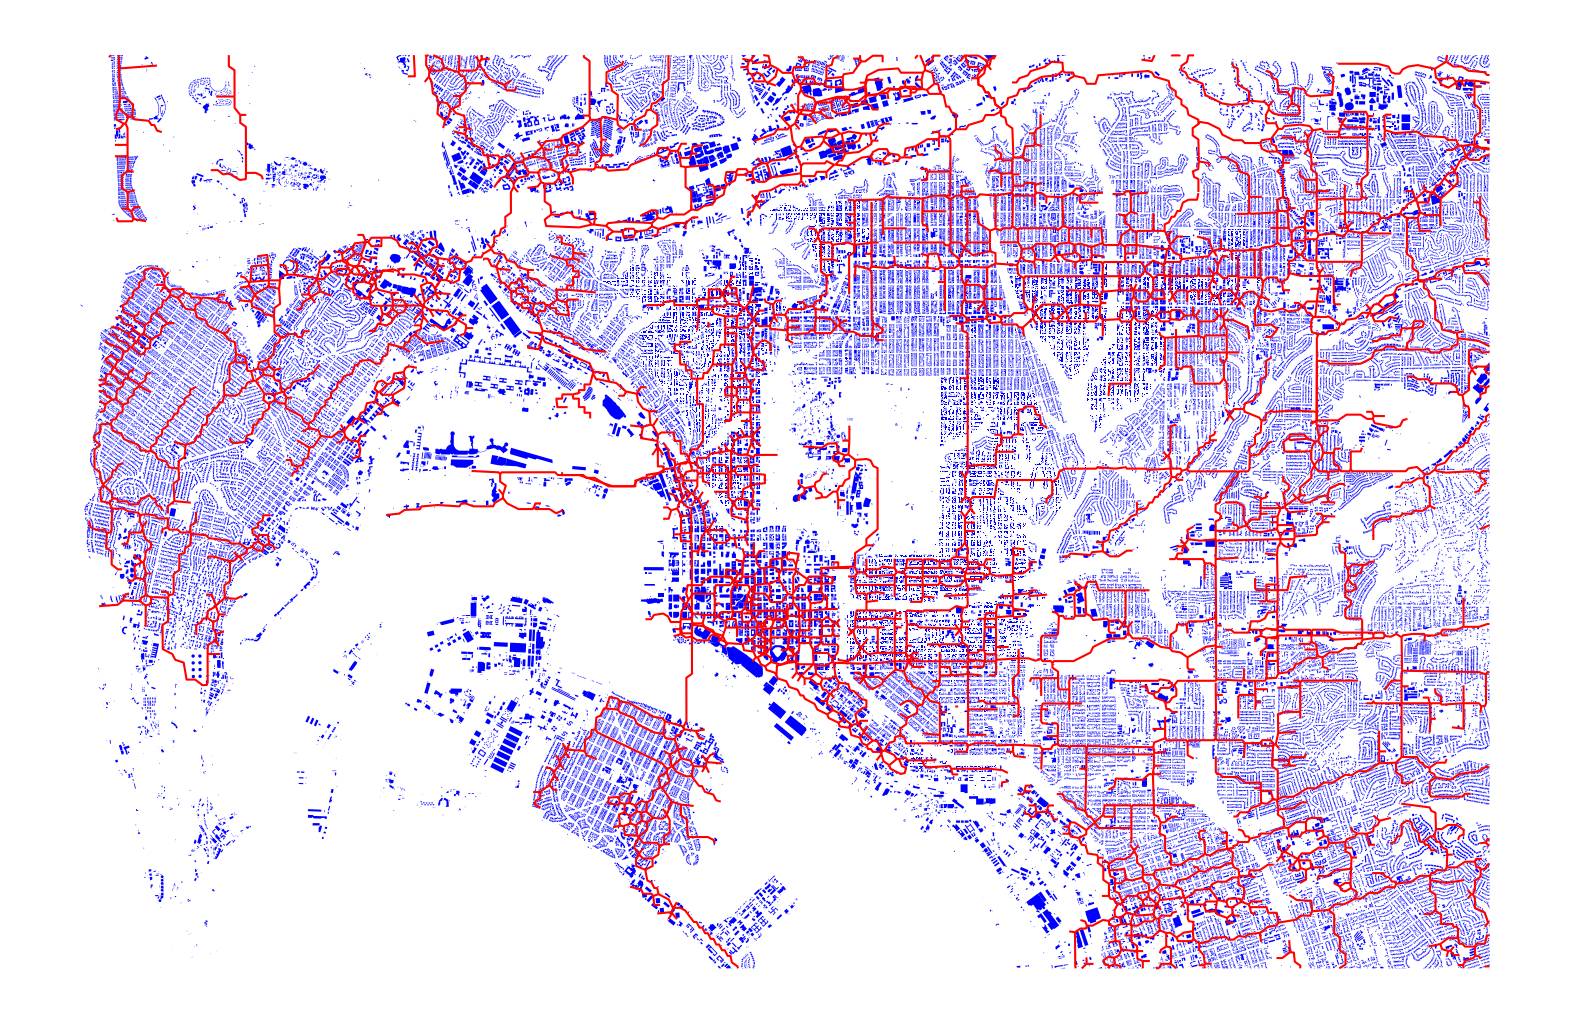

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.axis('off')

buildings_clip.plot(ax=ax, color='blue')

sdge_feederlines.plot(ax=ax, color='red')

# Link data

In [12]:
# Convert building footprints to centroid of building
buildings_clip['geometry'] = buildings_clip.centroid

/tmp/ipykernel_613867/2473613402.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings_clip['geometry'] = buildings_clip.centroid


In [15]:
sdge_data_linked = gpd.sjoin_nearest(buildings_clip, sdge_feederlines, how='left', distance_col='dist_to_line_m')

/Users/sofiarodas/.conda/envs/electrigrid-env/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [16]:
sdge_data_linked.head()

,source,id,height,var,region,bbox,geometry,index_right,SUBID,OBJECTID,...,ICAWNOF_UNIGENERATION,ICAWNOF_UNILOAD,ICAWNOF_PVGENERATION,LABELTEXT_ICA,RESTRICTED,ICAWOF_UNIGENERATION_LC,ICAWOF_UNILOAD_LC,ICAWNOF_UNIGENERATION_LC,substations,dist_to_line_m
7107089,osm,15966214,1.377874,0.991099,USA,"{'xmin': -117.24165519999998, 'ymin': 32.67039...",POINT (-117.24162 32.67042),10,CABRILLO,32570544,...,3.6,3.3,3.6,Up to 1.00,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,CABRILLO,0.033125
7107085,osm,67487419,2.999929,2.747906,USA,"{'xmin': -117.241352, 'ymin': 32.6716877, 'xma...",POINT (-117.24131 32.67173),10,CABRILLO,32570544,...,3.6,3.3,3.6,Up to 1.00,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,CABRILLO,0.031802
7107086,osm,133055012,3.113471,3.369538,USA,"{'xmin': -117.2409694, 'ymin': 32.6717891, 'xm...",POINT (-117.24091 32.67185),10,CABRILLO,32570544,...,3.6,3.3,3.6,Up to 1.00,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,CABRILLO,0.031669
7107101,osm,90687227,3.667810,3.329592,USA,"{'xmin': -117.2410468, 'ymin': 32.671931300000...",POINT (-117.24098 32.67199),10,CABRILLO,32570544,...,3.6,3.3,3.6,Up to 1.00,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,CABRILLO,0.031534
7107102,osm,1177231469,2.633681,1.875980,USA,"{'xmin': -117.2407876, 'ymin': 32.6720196, 'xm...",POINT (-117.24077 32.67203),10,CABRILLO,32570544,...,3.6,3.3,3.6,Up to 1.00,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,CABRILLO,0.031484


In [17]:
buildings_clip.head()

,source,id,height,var,region,bbox,geometry
7107089,osm,15966214,1.377874,0.991099,USA,"{'xmin': -117.24165519999998, 'ymin': 32.67039...",POINT (-117.24162 32.67042)
7107085,osm,67487419,2.999929,2.747906,USA,"{'xmin': -117.241352, 'ymin': 32.6716877, 'xma...",POINT (-117.24131 32.67173)
7107086,osm,133055012,3.113471,3.369538,USA,"{'xmin': -117.2409694, 'ymin': 32.6717891, 'xm...",POINT (-117.24091 32.67185)
7107101,osm,90687227,3.667810,3.329592,USA,"{'xmin': -117.2410468, 'ymin': 32.671931300000...",POINT (-117.24098 32.67199)
7107102,osm,1177231469,2.633681,1.875980,USA,"{'xmin': -117.2407876, 'ymin': 32.6720196, 'xm...",POINT (-117.24077 32.67203)


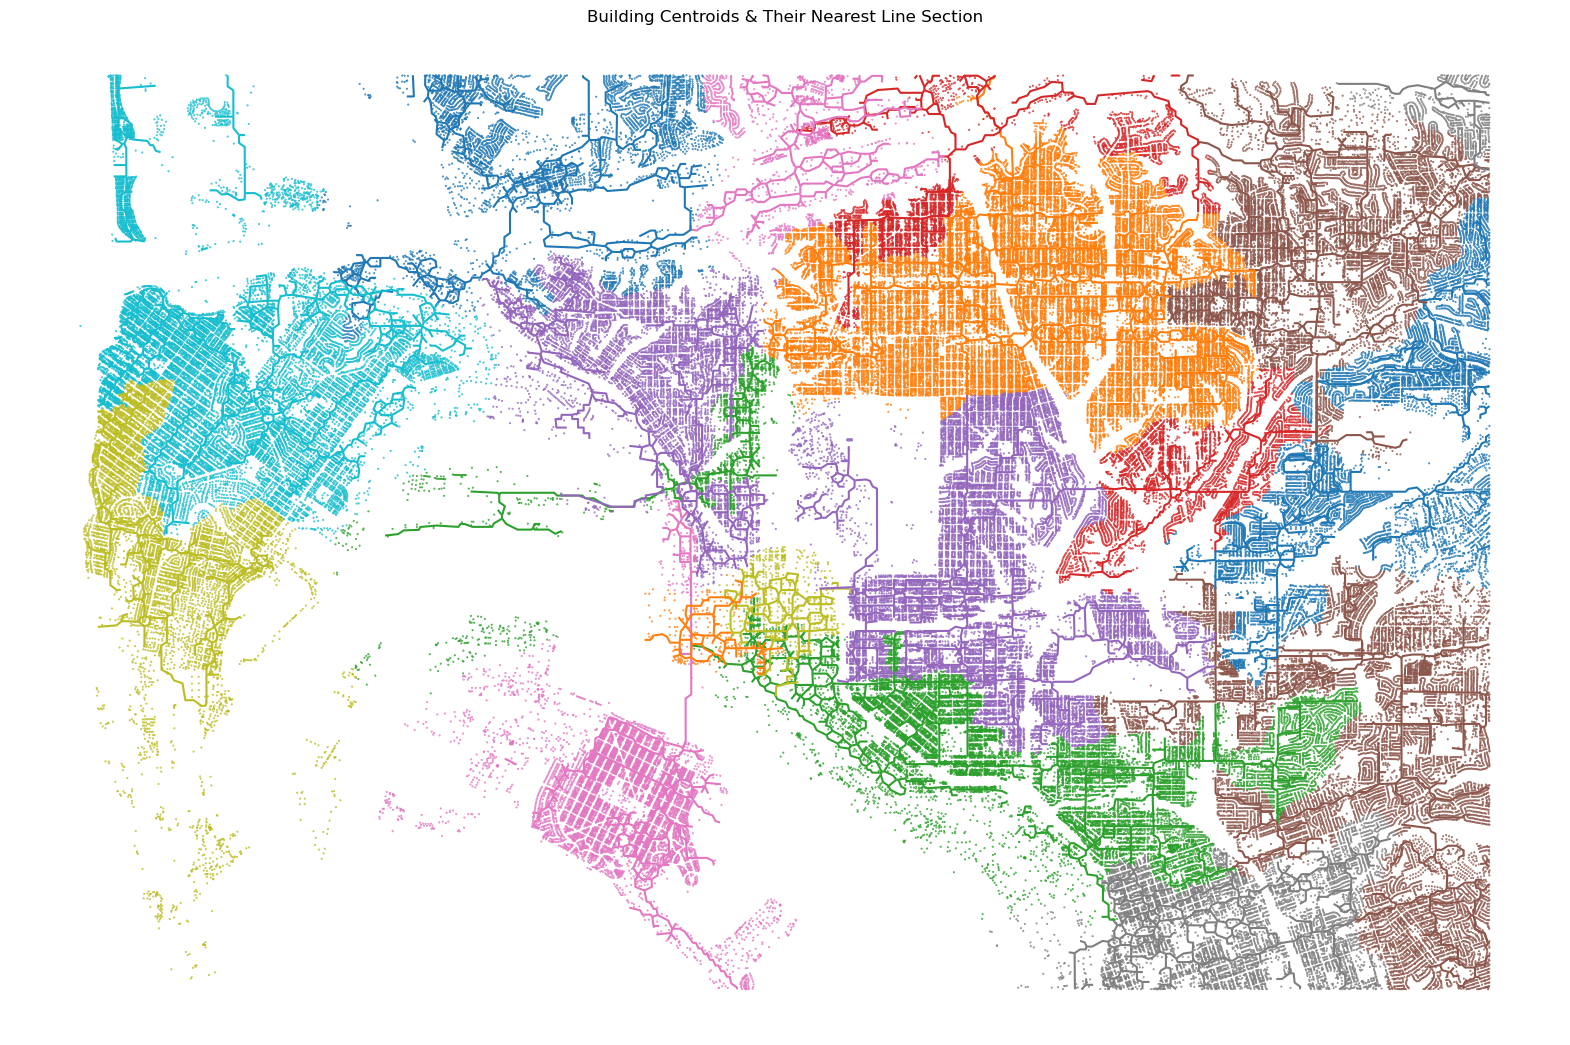

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.axis('off')

sdge_data_linked.plot(ax=ax, column='CIRCUIT_NAME', markersize=0.2)

sdge_feederlines.plot(ax=ax, column='CIRCUIT_NAME')

plt.title("Building Centroids & Their Nearest Line Section")
plt.show()

This is mapped by `CIRCUIT_NAME` investigate if the these are the feederlines. They seem too vast to be feederlines. 